In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder


from itertools import product
import gc
import random as python_random
import time


In [2]:
# Keras seeding to produce reproduciable results
np.random.seed(123)
python_random.seed(123)
tf.random.set_seed(1234)


In [3]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype in ["int32", "int64"]]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float16)
    df[int_cols]   = df[int_cols].astype(np.int16)
    
    return df

def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in tqdm(lags):
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left').fillna(0)
    return df


# Months choosen for lag
def lag_features(df, lags, ref_col, index_col, col_to_lag):
    '''
    ref_col: Reference column relative to which lag is measured
    lags: List of lag period
    index_col: Columns which will be static
    col_to lag: Columns on which lag has to be generated
    
    The function first makes a dataframe with index column and the columns which are
    to be lagged. Then it shifts the reference column forward to the lag period.
    Other column in the index remains the same. Then only new columns names are generated
    which represents the lag period but the values are same as original.
    
    Thus the reference column is shifted forward, the column names for lag column are suffixed
    with lag period and all other elements remain same. If original value of refernce column is 
    m, lag required is n. Then new reference value is m+n. The rename column is suffixed '_n'.
    The lag column value now shows value of n period back from the refernce perion.
    
    '''
    for month_shift in tqdm(lags):
        # Create a temp df
        lag_shift = df[index_cols + col_to_lag].copy()

        # Shift Month column value
        lag_shift[ref_col] = lag_shift[ref_col] + month_shift

        foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in col_to_lag else x
        lag_shift = lag_shift.rename(columns=foo)

        # Iteratively add all the lagging months
        df = pd.merge(df, lag_shift, on=index_cols, how='left').fillna(0)

    
    del lag_shift
    return df


def price_trend(df,col1,col2,col3):
    
    gb = (df.groupby([col1,col2])[col3].mean()
          .reset_index()
          .rename(columns = {col3:'avg_price'}))
    
    gb['shifted_avg_price'] = gb.groupby([col2])['avg_price'].shift(1)
    
    gb.drop('avg_price', axis=1, inplace=True)
    
    df = pd.merge(df,gb,on=[col1,col2])
    df['price_trend'] = df[col3] - df['shifted_avg_price']
    df.drop(['shifted_avg_price'], axis=1, inplace=True)
    
    del gb
    
    return df.fillna(0)

gc

<module 'gc' (built-in)>

### Load Data

In [4]:
# Read the data into variable

train = pd.read_csv('./final_project_data/sales_train.csv')
items = pd.read_csv('./final_project_data/items.csv')
category = pd.read_csv('./final_project_data/item_categories.csv')
shops = pd.read_csv('./final_project_data/shops.csv')
test = pd.read_csv('./final_project_data/test.csv')

In [5]:
# Copy the original dataset to temp 
sales = train.copy()
sales_test = test.copy()

sales_index = sales_test['ID']
sales_test.drop_duplicates()
print(f' before duplicate drop:{test.shape}  after duplicate drop:{sales_test.shape}')

 before duplicate drop:(214200, 3)  after duplicate drop:(214200, 3)


In [6]:
sales_33 = sales.loc[sales['date_block_num'] == 33]
item_sales_last_month = sales_33.groupby(['shop_id','item_id'])['item_cnt_day'].sum().reset_index()
item_price_last_month = sales_33.groupby(['shop_id','item_id'])['item_price'].mean().reset_index()
# sales_last_month.head()

In [7]:
sales_test['date_block_num'] = 34
sales_test = sales_test.merge(item_sales_last_month, on=['shop_id', 'item_id'], how='left').fillna(0)
sales_test = sales_test.merge(item_price_last_month, on=['shop_id', 'item_id'], how='left').fillna(0)
sales_test.drop('ID', axis=1, inplace=True)
# sales_test.head()
sales_test.shape

(214200, 5)

In [8]:
print(sales.shape)
sales = sales.append(sales_test, ignore_index=True, sort=False)
print(sales.shape)
sales.tail()

(2935849, 6)
(3150049, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
3150044,NaN,34,45,18454,99.0,1.0
3150045,NaN,34,45,16188,0.0,0.0
3150046,NaN,34,45,15757,0.0,0.0
3150047,NaN,34,45,19648,0.0,0.0
3150048,NaN,34,45,969,0.0,0.0


In [9]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
#shops
shop_city = shops[['shop_id','city_code']].drop_duplicates()


In [10]:
category['split'] = category['item_category_name'].str.split('-')
category['type'] = category['split'].map(lambda x: x[0].strip())
category['type_code'] = LabelEncoder().fit_transform(category['type'])

category['subtype'] = category['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
category['subtype_code'] = LabelEncoder().fit_transform(category['subtype'])
category = category[['item_category_id','type_code', 'subtype_code']]

item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()


In [11]:
sales = pd.merge(sales, item_category_mapping, how='left', on='item_id')

sales = pd.merge(sales, category, on=['item_category_id'], how='left')

sales = pd.merge(sales, shop_city, on=['shop_id'], how='left')


### Get a feature matrix

* itertools.product(*iterables):

It returns the cartesian product of all the itrable provided as the argument. For example, product(arr1, arr2, arr3).

In [12]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

    # Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)


### Mean Encoding

In [13]:
# Groupby data to get shop-item-month aggregates
# Rename the aggregate column to target
gb = (sales.groupby(index_cols,as_index=False)['item_cnt_day']
          .sum()
          .rename(columns = {'item_cnt_day':'target'}))

# Join it to the grid
# grid is formed by all combination of unique shop,ite,month hence is many more rows,
# Joining grid with gb will result in the target column of gb having NaNs
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)
# all_data.head()

In [14]:
all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')

all_data = pd.merge(all_data, category, on=['item_category_id'], how='left')

all_data = pd.merge(all_data, shop_city, on=['shop_id'], how='left')


In [15]:
# Same as above but with shop-month aggregates
gb = (sales.groupby(['shop_id', 'date_block_num'],as_index=False)['item_cnt_day']
          .sum()
          .rename(columns = {'item_cnt_day':'target_shop'}))

#gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)


In [16]:
# Same as above but with item-month aggregates
gb = (sales.groupby(['item_id', 'date_block_num'],as_index=False)['item_cnt_day']
          .sum().rename(columns = {'item_cnt_day':'target_item'}))

all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)
#all_data.head()

In [17]:
# Mean Price for each item
gb = sales.groupby(index_cols,as_index=False)['item_price'].mean()

all_data = pd.merge(all_data, gb, how='left', on=index_cols).fillna(0)



In [18]:
gb = (sales.groupby(['date_block_num', 'item_category_id'])
                 .agg({'item_cnt_day': 'mean'})
                 .rename(columns = {'item_cnt_day':'date_cat_avg_item_cnt'})
                 .reset_index())

all_data = pd.merge(all_data, gb, how='left', on=['date_block_num', 'item_category_id'])


In [19]:
gb = (sales.groupby(['date_block_num','shop_id','item_category_id'])
                 .agg({'item_cnt_day': 'mean'})
                 .rename(columns = {'item_cnt_day':'date_shop_cat_avg_item_cnt'})
                 .reset_index())
all_data = pd.merge(all_data, gb, how='left', on=['date_block_num','shop_id','item_category_id'])


In [20]:
# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid
gc.collect();

### Lag feature

After creating a grid, we can calculate some features. We will use lags from [1, 2, 3, 4, 5, 12] months ago.

In [21]:
all_data = lag_features(all_data,[1,2, 3,4], 'date_block_num',index_cols,['target'])

100%|██████████| 4/4 [00:43<00:00, 10.77s/it]


In [22]:
all_data = (lag_features(all_data,[1,2], 'date_block_num',index_cols,
             ['target_shop','target_item','date_cat_avg_item_cnt','item_price',
              'date_shop_cat_avg_item_cnt']))

all_data.drop(['target_shop','target_item','date_cat_avg_item_cnt','item_price',
              'date_shop_cat_avg_item_cnt'], axis=1,inplace=True)


100%|██████████| 2/2 [00:30<00:00, 15.03s/it]


In [23]:
all_data.shape

(11128050, 22)

In [24]:
# Item sold on a type code
gb = (sales.groupby(['date_block_num','type_code'])
                 .agg({'item_cnt_day': 'mean'})
                 .rename(columns = {'item_cnt_day':'date_type_cat_avg_item_cnt'})
                 .reset_index())
all_data = pd.merge(all_data, gb, how='left', on=['date_block_num','type_code'])


In [25]:
# Item sold on a subtype code
gb = (sales.groupby(['date_block_num','subtype_code'])
                 .agg({'item_cnt_day': 'mean'})
                 .rename(columns = {'item_cnt_day':'date_subtype_cat_avg_item_cnt'})
                 .reset_index())
all_data = pd.merge(all_data, gb, how='left', on=['date_block_num','subtype_code'])


In [26]:
all_data = (lag_features(all_data,[1,2], 'date_block_num',index_cols, 
                         ['date_type_cat_avg_item_cnt', 'date_subtype_cat_avg_item_cnt']))

all_data.drop(['date_type_cat_avg_item_cnt','date_subtype_cat_avg_item_cnt'], axis=1,inplace=True)


100%|██████████| 2/2 [00:40<00:00, 20.31s/it]


In [27]:
gb = (sales.groupby(['date_block_num', 'city_code'])
                 .agg({'item_cnt_day': 'mean'})
                 .rename(columns = {'item_cnt_day':'date_city_avg_item_cnt'})
                 .reset_index())

all_data = pd.merge(all_data, gb, how='left', on=['date_block_num', 'city_code'])


#### try out

In [28]:
# all_data = (lag_features(all_data,[1], 'date_block_num',index_cols, ['date_city_avg_item_cnt']))

# all_data.drop('date_city_avg_item_cnt', axis=1,inplace=True)


In [29]:
# stop

In [30]:
del gb, sales, sales_test
gc.collect();

In [31]:
# # Category for each item


all_data = all_data.fillna(0)
all_data = downcast_dtypes(all_data)
all_data['shop_id'] = all_data['shop_id'].astype(np.int8)
all_data['item_id'] = all_data['item_id'].astype(np.int8)
all_data['city_code'] = all_data['city_code'].astype(np.int8)
all_data['date_block_num'] = all_data['date_block_num'].astype(np.int8)

gc.collect();

In [32]:
all_data.tail(5).T

,11128045,11128046,11128047,11128048,11128049
shop_id,45.000000,45.000000,45.000000,45.000000,45.000000
item_id,22.000000,60.000000,-115.000000,-64.000000,-55.000000
date_block_num,34.000000,34.000000,34.000000,34.000000,34.000000
target,1.000000,0.000000,0.000000,0.000000,0.000000
item_category_id,55.000000,64.000000,55.000000,40.000000,37.000000
type_code,13.000000,14.000000,13.000000,11.000000,11.000000
subtype_code,2.000000,42.000000,2.000000,4.000000,1.000000
city_code,20.000000,20.000000,20.000000,20.000000,20.000000
target_lag_1,1.000000,0.000000,0.000000,0.000000,0.000000
target_lag_2,0.000000,0.000000,0.000000,0.000000,0.000000


In [33]:
all_data.dtypes

shop_id                                   int8
item_id                                   int8
date_block_num                            int8
target                                 float16
item_category_id                         int16
type_code                                int16
subtype_code                             int16
city_code                                 int8
target_lag_1                           float16
target_lag_2                           float16
target_lag_3                           float16
target_lag_4                           float16
target_shop_lag_1                      float16
target_item_lag_1                      float16
date_cat_avg_item_cnt_lag_1            float16
item_price_lag_1                       float16
date_shop_cat_avg_item_cnt_lag_1       float16
target_shop_lag_2                      float16
target_item_lag_2                      float16
date_cat_avg_item_cnt_lag_2            float16
item_price_lag_2                       float16
date_shop_cat

In [34]:
# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12] 


to_drop_cols = ['target','item_category_id','date_block_num']

In [35]:
# all_data.drop('shop_item', axis=1, inplace=True)

To this end, we've created a feature matrix. It is stored in ```all_data variable```. Take a look:

### train/ validation/test split

34th month data is the test set. 32nd and 33rd data will be taken as validation split and rest as training data.

In [36]:
# Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts 
dates = all_data['date_block_num']


X_train = all_data.loc[(dates <  32)].drop(to_drop_cols, axis=1)
X_val = all_data.loc[(dates ==  33) | (dates ==  32)].drop(to_drop_cols, axis=1)
X_test =  all_data.loc[dates == 34].drop(to_drop_cols, axis=1)

y_train = all_data.loc[(dates <  32), 'target'].values
y_val =  all_data.loc[((dates ==  33) | (dates ==  32)), 'target'].values

gc.collect();

In [37]:
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 


Using TensorFlow backend.


In [38]:
def build_model():
    model = keras.Sequential([
        layers.Dense(128, activation='relu',input_shape=[X_train.shape[1]]),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
       layers.Dense(1)
      ])

    #optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0)
    optimizer='rmsprop'
    
    model.compile(loss=root_mean_squared_error,
                optimizer=optimizer,
                metrics=['mse',])
    return model

In [39]:
# keras_model = build_model()

# EPOCHS = 10

# history = keras_model.fit(
#   X_train, y_train,
#   epochs=EPOCHS,
#     batch_size=100,
#     validation_data=(X_val, y_val),
#     #callbacks=[callbacks],
#   )

In [40]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model accuracy')
# plt.ylabel('loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# # plt.ylim(bottom=10, top=12)
# # plt.xlim(left=1100, right = 1200)
# plt.grid()
# plt.show()

In [41]:
# # Preprocessing of test data, fit model
# preds_test = keras_model.predict(X_test)

# # The prediction is of type numpy.ndarray
# preds_list = preds_test.tolist()

# # Extract the prediction and put it in a list
# prediction = []
# for item in preds_list:
#     prediction.append(item[0])

# prediction = np.clip(prediction, 0, 20)

In [42]:
xgb_model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)


In [43]:
start = time.time()
xgb_model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    verbose=True, 
    early_stopping_rounds = 3)

time.time() -start

[08:59:01] WARNING: /workspace/src/gbm/gbtree.cc:138: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:3.01981	validation_1-rmse:5.95421
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 3 rounds.
[1]	validation_0-rmse:2.82771	validation_1-rmse:5.86166
[2]	validation_0-rmse:2.70392	validation_1-rmse:5.79230
[3]	validation_0-rmse:2.62325	validation_1-rmse:5.73081
[4]	validation_0-rmse:2.56773	validation_1-rmse:5.70085
[5]	validation_0-rmse:2.51990	validation_1-rmse:5.65933
[6]	validation_0-rmse:2.50223	validation_1-rmse:5.63796
[7]	validation_0-rmse:2.47650	validation_1-rmse:5.61917
[8]	validation_0-rmse:2.45670	validation_1-rmse:5.58394
[9]	validation_0-rmse:2.43578	validation_1-rmse:5.57831
[10]	validation_0-rmse:2.41859	validation_1-rmse:5.56800
[11]	val

546.4414916038513

In [44]:
preds = xgb_model.predict(X_test).clip(0, 20)

prediction = (np.clip(preds, 0, 20)).tolist()

In [45]:
# Save test predictions to file
output = pd.DataFrame({'ID': sales_index,
                       'item_cnt_month': prediction})


In [46]:
# output.to_csv('XbgModel.csv', index=False)
# output.to_csv('KerasModel.csv', index=False)
output.to_csv('XGBModel.csv', index=False)

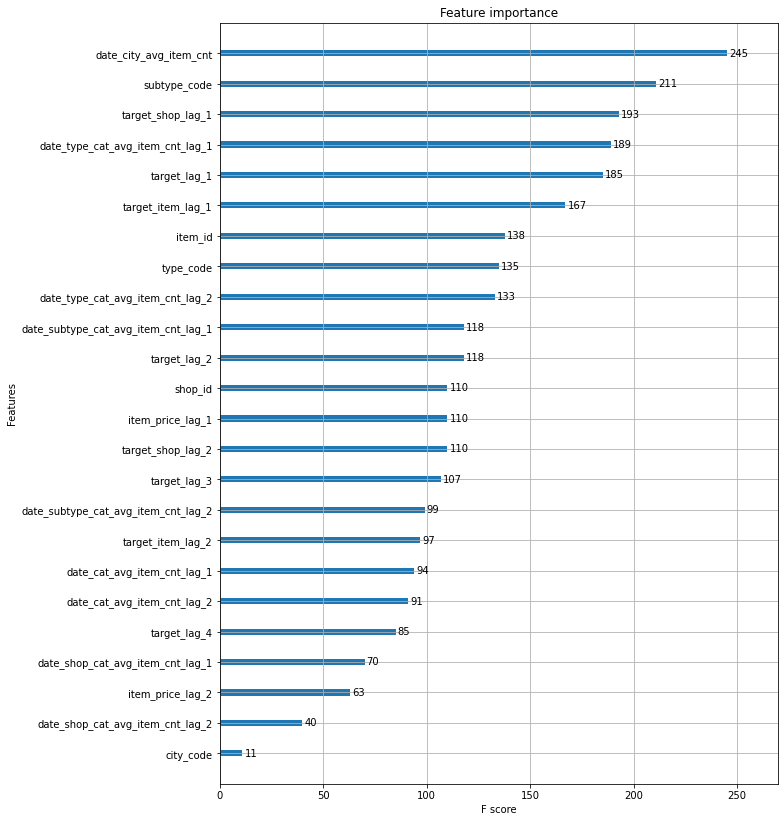

In [47]:
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(xgb_model, (10,14))

In [48]:
# file1 = 'KerasModel.csv'
# k1 =pd.read_csv(file1)
# file2 = 'XGBModel.csv'
# k2 =pd.read_csv(file2)
# k2['item_cnt_month'] = (k2['item_cnt_month'] + k1['item_cnt_month'])/2
# k2.to_csv('KerasModel_mean.csv', index=False)